# Vapor Python Overview *(Currently an outline)*

Draft, few things to consider:
* How much detail? For example, when we call `camera.LookAt()` should we mention that it takes `[position, target]`?
* Add more descriptions in general
* How to get data? Might be too big for GitHub, url link might work better

Goal: provide general info in form of a workflow with an example dataset. Assumption is that most users come from a 2D viz background, so we want to explain 3D / vapor specific terms, such as session file, camera angles, etc. Use an example dataset and showcase a workflow from front to back

In [1]:
from vapor import session, renderer, dataset, camera, utils
from vapor.animation import Animation
import numpy as np

Vapor 3.9.2
Python 3.9.19 (/opt/anaconda3/envs/vapor)
OpenGL 4.1 Metal - 83.1


## Import Data

[Info about session files]

In [2]:
ses = session.Session()

[Overview of file formats. Specify format, then load files]

In [52]:
data = ses.OpenDataset(dataset.WRF, ["wrfout_d02_2005-08-29_02"])

[Info about dataset]

Too much info? Could potentially describe it instead of printing it all out. Or just print metadata for variables being used

In [53]:
data.GetCoordVarNames()

['Time',
 'XLAT',
 'XLAT_U',
 'XLAT_V',
 'XLONG',
 'XLONG_U',
 'XLONG_V',
 'bottom_top',
 'bottom_top_stag',
 'soil_layers_stag',
 'Elevation',
 'ElevationU',
 'ElevationV',
 'ElevationW',
 'XLATY',
 'XLAT_UY',
 'XLAT_VY',
 'XLONGX',
 'XLONG_UX',
 'XLONG_VX']

In [54]:
for dim in data.GetDimensionNames():
    print(f" {dim}:", data.GetDimensionLength(dim, 0))

 DateStrLen: 19
 Time: 1
 bottom_top: 34
 bottom_top_stag: 35
 ext_scalar: 1
 soil_layers_stag: 5
 south_north: 309
 south_north_stag: 310
 west_east: 315
 west_east_stag: 316


In [55]:
print("Data Variables:")
for var in data.GetDataVarNames():
    print(f" {var}")
    print(f"    Time Varying: False")
    print(f"    Dimensionality:", data.GetVarGeometryDim(var))
    print(f"    Coordinates:", data.GetVarCoordVars(var, True))
    print("     Data Range:", data.GetDataRange(var))

Data Variables:
 CANWAT
    Time Varying: False
    Dimensionality: 2
    Coordinates: ['XLONGX', 'XLATY']
     Data Range: [-1.0, 0.0]
 COSALPHA
    Time Varying: False
    Dimensionality: 2
    Coordinates: ['XLONGX', 'XLATY']
     Data Range: [1.0, 1.0]
 E
    Time Varying: False
    Dimensionality: 2
    Coordinates: ['XLONGX', 'XLATY']
     Data Range: [0.00012237085320521146, 0.00013558348291553557]
 F
    Time Varying: False
    Dimensionality: 2
    Coordinates: ['XLONGX', 'XLATY']
     Data Range: [5.372547093429603e-05, 7.933902088552713e-05]
 GLW
    Time Varying: False
    Dimensionality: 2
    Coordinates: ['XLONGX', 'XLATY']
     Data Range: [413.1957702636719, 474.07501220703125]
 GRDFLX
    Time Varying: False
    Dimensionality: 2
    Coordinates: ['XLONGX', 'XLATY']
     Data Range: [0.0, 0.0]
 HFX
    Time Varying: False
    Dimensionality: 2
    Coordinates: ['XLONGX', 'XLATY']
     Data Range: [-132.50840759277344, 339.16357421875]
 HGT
    Time Varying: False
    

## Apply Renderers

Info: what's a renderer? What kinds of renderes does vapor provide?

Somewhere I should give info about camera features and transfer functions

### 2D Data Renderer
We will use the `LANDMASK` variable to shade surface with land or water.

In [56]:
land = data.NewRenderer(renderer.TwoDDataRenderer)
land.SetVariableName("LANDMASK")
land_tf = land.GetTransferFunction("LANDMASK")
land_tf.LoadBuiltinColormap("Diverging/delta")

0

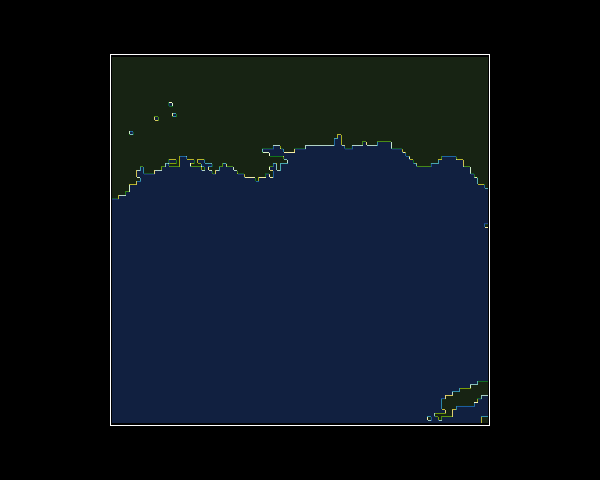

In [57]:
ses.GetCamera().ViewAll()
ses.Show()

### Volume Renderer

The `QCLOUD` variable measures the cloud thickness (?) at every gridpoint. We can use a volume renderer to display where the clouds are thickest.

In [58]:
clouds = data.NewRenderer(renderer.VolumeRenderer)
clouds.SetVariableName("QCLOUD")

We can customize renderer as desired. First we will set the colors to be on a white-gray-black scale. Then we will edit the opacities of the renderer. We want areas with almost no clouds to be completely transparent, while areas with more clouds to be more obaque.

In [59]:
clouds_tf = clouds.GetTransferFunction("QCLOUD")
clouds_tf.LoadBuiltinColormap("Sequential/BlackWhite")
new_colors = [(r, g, b) for r, g, b, _ in list(reversed(clouds_tf.GetMatPlotLibColormap().colors))]
clouds_tf.SetColorRGBList(new_colors)
clouds_tf.SetOpacityControlPoints([[0,0],[0.00001,0.01], [0.0001, 0.1], [0.0010,0.9]])

We will set our camera at an angle so that we can see the 3D structure of the clouds.

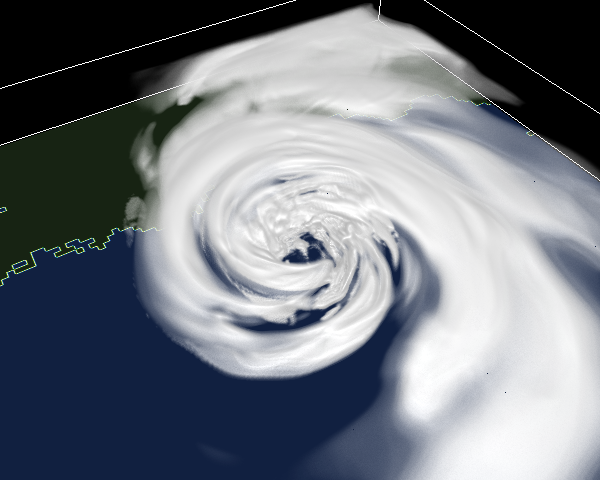

In [60]:
ses.GetCamera().LookAt([-420811.28125 * 1.8, 2737271.75 * 0.8, 1904108.375 * 0.4], [-420811.28125, 2737271.75, 10466.52343731 * 1.5])
ses.Show()

Finally, we can create an animation to rotate the camera. We keep the target fixed while rotating our camera.

Camera angles are currently very adhock. Find better way?

In [62]:
anim = Animation(ses)
ses.GetCamera().LookAt([-420811.28125 * 1.8, 2737271.75 * 0.8, 1904108.375 * 0.4], [-420811.28125, 2737271.75, 10466.52343731 * 1.5])
nframes = 100
for i in range(0, nframes, 1):
    ses.GetCamera().LookAt([(-420811.28125 * 1.8) + (5000 * i), 2737271.75 * 0.8, (1904108.375 * 0.4) - (50000 * 0)], [-420811.28125, 2737271.75, 10466.52343731 * 1.5])
    anim.CaptureFrame()
    print(f"Rendering Animation [{'#'*round(i*40/nframes)}{' '*round(40-(i*40/nframes))}] {(i+1)*100/nframes:.0f}%", end="\r")

In [63]:
anim.Show()

## Add Annotations

TODO

## Export

Discuss save session -> open in GUI / other python script

In [ ]:
ses.Save("Katrina.vs3")

Save visuals

In [4]:
# TODO